# LLM from scratch

This is a university diploma project crafted by Mihajlo Madzarevic with the help of lectures provided by Andrej Karpathy on making a LLM from scratch.

## Imports and data loading

In [57]:
# Module imports

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch
# (nn - neural net) Module, dataset loading
import torch.nn as nn
# conv, pool layers, attention mechanism, activation functions...
from torch.nn import functional as F
# Check whether we're on gpu or not
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device used for training: %s" % device)

import os

print("Loading the following texts: ")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Device used for training: cuda
Loading the following texts: 
/kaggle/input/meditations-marcus-aurelius/meditations.txt


In [58]:
# Params

# How many tokens you want for predicting.
# Tokens can be words/chars/subwords...
block_size = 8
# How many examples of blocks per batch for training.
batch_size = 8
# How many times the model should be evaluated.
eval_iters = 10

In [59]:
# Function that loads and cleans data.
def load_clean_data():
    # Using with so it properly closes the resource
    # in this case the file (we don't have to call file.close())
    with open('/kaggle/input/meditations-marcus-aurelius/meditations.txt', 'r', encoding='utf-8') as file:
        text = file.read()
        
        # CHAR PROCESSING
        
        chars_from_text = sorted(list(set(text.lower())))
        
        # Get rid of numbers and unnecessary symbols.
        chars_from_text_tmp = []
        for char in chars_from_text:
            # Look for only letters by ASCII value.
            if ord(char) >= 97 and ord(char) <= 122:
                chars_from_text_tmp.append(char)
                
        # Manually add needed symbols.
        chars_from_text_tmp.insert(0, "?")
        chars_from_text_tmp.insert(0, "!")
        chars_from_text_tmp.insert(0, ".")
        chars_from_text_tmp.insert(0, " ")
        
        chars_from_text = chars_from_text_tmp
        
        vocab_size_chars = len(chars_from_text)
        
        print("Chars vocab size: ", vocab_size_chars, "\n")
        print("Sampled and cleaned chars from text: ", chars_from_text, "\n\n")
        
        # WORD PROCESSING
        
        text_lowered_split = text.lower().split()
        words_from_text = sorted(list(set(text_lowered_split)))
        
        # Function to display data that might be misleading for our model.
        unuseful_words = []
        for word in words_from_text:
            if len(word) < 4 and word not in unuseful_words:
                unuseful_words.append(word)

        print("Words that might be misleading for our model: ", unuseful_words, " \n\n")
        
        # Remove number containing words from the dataset and
        # also strip words from punctuation and symbols.
        words_from_text_tmp = []
        for word in words_from_text:
            if not any(char.isdigit() for char in word):
                words_from_text_tmp.append(word.replace('"', '').strip("!,./\?')(_"))
                
        words_from_text = words_from_text_tmp

    vocab_size_words = len(words_from_text)
    
    print("Words vocab size: ", vocab_size_words, "\n")
    print("Sampled and cleaned words from text: ", words_from_text[:100])
    
    
    # CHAR / WORD VOCAB SIZE DIFFERENCE VISUALIZATION

    barplot_data = pd.DataFrame({
        'Category': ['Words', 'Chars'],
        'Count': [vocab_size_words, vocab_size_chars]
    })
    
    plt.figure(figsize=(10,6))
    plt.title("Vocab size difference for words and chars as tokens.")
    sns.barplot(x='Category', y='Count', data=barplot_data)
    plt.ylabel("Number of tokens")
    plt.show()
    
    return vocab_size_words, vocab_size_chars, text, words_from_text, chars_from_text

Chars vocab size:  30 

Sampled and cleaned chars from text:  [' ', '.', '!', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 


Words that might be misleading for our model:  ['"a', '"as', '"do', '"en', '"i', '"it', '"m.', '"my', '"or', '"to', '&c.', "'a", "'as", "'be", "'do", "'he", "'i", "'if", "'in", "'it", "'m.", "'my", "'no", "'o", "'o,", "'of", "'to", "'we", '(1)', '(2)', '(3)', '(4)', '(5)', '(6)', '(7)', '(8)', '(a', '(as', '(be', '(c.', '(he', '(if', '(in', '(is', '(of', '(or', '(to', '(v.', '1', '1,', '1.', '10.', '11', '12', '12.', '14', '140', '143', '145', '169', '17', '17,', '174', '19', '19.', '2', '2.', '21.', '22,', '22.', '250', '26,', '28', '28,', '287', '2nd', '3,', '3.', '31', '345', '350', '353', '37.', '373', '4.', '412', '44.', '46', '486', '4th', '5.', '512', '5th', '6,', '6.', '66', '6th', '7', '7,', '7.', '757', '79', '8.', '839', '898', '9th', '[1]', '[2]', '[3]', '[4]', 

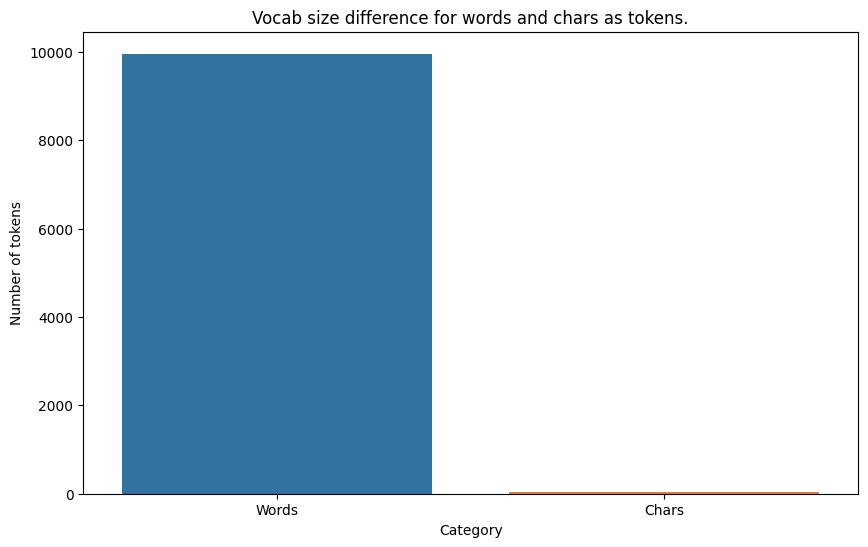

In [60]:
vocab_size_words, vocab_size_chars, text, words_from_text, chars_from_text = load_clean_data()

## Data preparation for the model

In [76]:
# CHARS ENCODER DECODER

char_to_int = { char:i for i,char in enumerate(chars_from_text) }
int_to_char = { i:char for i,char in enumerate(chars_from_text) }
encode_chars = lambda char_sequence: [char_to_int[char] for char in char_sequence if char in char_to_int]
decode_chars = lambda int_sequence: ''.join([int_to_char[i] for i in int_sequence if i in int_to_char])

# WORDS ENCODER DECODER

# Encoder and decoder
# These are responsible for turning our tokens from a text format to a number format
# so that the model can use them for predicting. Remember that computers cannot understand
# text, only numbers!
word_to_int = { word:i for i,word in enumerate(words_from_text) }
int_to_word = { i:word for i,word in enumerate(words_from_text) }
encode_words = lambda word_sequence: [word_to_int[word] for word in word_sequence if word in word_to_int]
decode_words = lambda int_sequence: ' '.join([int_to_word[i] for i in int_sequence if i in int_to_word])

# This is our whole data(text from the book) that we're going to use to
# train and evaluate the model. The data is encoded(all the tokens are transformed
# into a number format).
# For example:
# a -> 1
# b -> 2
# c -> 3
# or if our tokens we're words
# cat -> 1
# dog -> 2
# have -> 3
chars_data = torch.tensor(encode_chars(text), dtype=torch.long)
words_data = torch.tensor(encode_words(text), dtype=torch.long)

In [77]:
# The function for splitting data for training and validation
def train_val_split(data, split_rate=0.8):
    split = int(split_rate * len(data))
    train_data = data[:split]
    val_data = data[split:]

    return train_data, val_data

In [78]:
chars_train_data, chars_val_data = train_val_split(chars_data)
words_train_data, words_val_data = train_val_split(words_data)

In [79]:
# A function to split data into batches so we don't
# give the model everything while training it, but
# chunks of data by chunks of data.
def get_batch(train_data, val_data, data_type='train'):
    data = train_data if data_type == 'train' else val_data
    rand_batch_selection = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+batch_size] for i in rand_batch_selection])
    y = torch.stack([data[i+1:i+batch_size+1] for i in rand_batch_selection])
    x.to(device), y.to(device)
    return (x,y)

## The model variants

In [80]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # We make an embedding table to know how related
        # are the words/chars to each other. Which one we should place next.
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        
    # Forward propagation of our input throught the model to see what we get as output.
    # These results later get used for backwards propagation to update the weights of the model.
    def forward(self, index, targets=None):
        index = index.to(self.token_embedding_table.weight.device)
        
        probs = self.token_embedding_table(index)
        
        if targets == None:
            # If we don't have the targets, we don't have a reference on which to calculate the loss
            loss = None
        else:
            # Make sure the targets are on the same device as the embedding table (cpu/gpu)
            targets = targets.to(self.token_embedding_table.weight.device)
            
            # We do this reshaping of the probabilities because torch has certain rules on
            # how it expects its data shape to be
            B, T, C = probs.shape # Batch - how many context examples do we give the model, Time - tokens(what is the next char/word), Channels - vocabulary size
            probs = probs.view(B*T, C)
            targets = targets.view(B*T)
            # We calculate the differences between our models probabilities and what they should actually be
            # to know what is our loss and how well the model is performing.
            loss = F.cross_entropy(probs, targets)
        
        return probs, loss
        
    # Function to generate the next token in the sequence based on the context it was provided.
    def generate(self, idx, generate_max_tokens):
        for _ in range(generate_max_tokens):
            # Forward propagation to obtain probabilities and the loss.
            probs, loss = self(idx)
            # Take the last tokens probabilities for the next token to be generated in the sequence.
            probs = probs[:, -1, :]
            # We apply the softmax function to normalize and "smooth" the selection.
            probs = F.softmax(probs, dim=-1)
            # Pick the most probable token in the sequence with the multinomial distribution.
            idx_next = torch.multinomial(probs, num_samples=1)
            # And at the end concatenate it to the previous context.
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
        
            
model_chars = BigramLanguageModel(vocab_size_chars)
# Make sure the model is on the same device as the rest of the data.
mc = model_chars.to(device)
model_words = BigramLanguageModel(vocab_size_words)
mw = model_words.to(device)

In [81]:
# Function for average estimation of loss.
# It is used to get a better view on what the loss is.
# Model type can be either 'chars' or 'words'.
def estimate_loss(model_type):
    out = {}
    # Turn on validation mode.
    if model_type == 'chars':
        mc.eval()
    else:
        mw.eval()
    # We turn off gradient calculation here
    # because we're just evaluating the model not training it.
    # (We aren't updating the weights!!!)
    with torch.no_grad():
        for data_type in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for i in range(eval_iters):
                x, y = None, None
                probs, loss = None, None
                if model_type == 'chars':
                    x, y = get_batch(chars_train_data, chars_val_data, data_type)
                    # Could be also called logits.
                    # Logits are unnormalized probabilities!
                    probs, loss = mc(x, y)
                else:
                    x, y = get_batch(words_train_data, words_val_data, data_type)
                    # Could be also called logits.
                    # Logits are unnormalized probabilities!
                    probs, loss = mw(x, y)
                # Gives us just the loss value from tensor.
                losses[i] = loss.item()
            # Add data to the plot so it can be displayed.
            plt.plot(losses, label=data_type)
            out[data_type] = losses.mean()
    plt.title("Model loss estimation")
    plt.ylabel("Loss")
    plt.xlabel("Eval iteration")
    plt.legend()
    plt.show()
    # Turn the training mode after the eval mode.
    if model_type == 'chars':
        mc.train()
    else:
        mw.train()
    return out

In [82]:
# The optimizer which will be used to update the weights and biases of the model
# during back propagation.
optimizer_chars = torch.optim.AdamW(mc.parameters(), lr=1e-3)
optimizer_words = torch.optim.AdamW(mw.parameters(), lr=1e-3)

In [83]:
# Model type can be either 'chars' or 'words'.
def train(model_type, steps=1000, loss_freq_tracking = 100):
    # Evaluate loss every loss_freq_tracking steps.
    losses = torch.zeros(steps//loss_freq_tracking)
    for step in range(steps):
        x, y = None, None
        probs, loss = None, None
        # For char models.
        if model_type == 'chars':
            x, y = get_batch(chars_train_data, chars_val_data)
            probs, loss = mc(x, y)
            optimizer_chars.zero_grad(set_to_none=True)
            loss.backward()
            optimizer_chars.step()
        # For word models.
        else:
            x, y = get_batch(words_train_data, words_val_data)
            probs, loss = mw(x, y)
            optimizer_words.zero_grad(set_to_none=True)
            loss.backward()
            optimizer_words.step()
        if step % loss_freq_tracking:
            losses[step//loss_freq_tracking] = loss.item()
    
    # Plot for the loss during training.
    plt.plot(losses, label="loss")
    plt.title("Loss during training")
    plt.ylabel("Loss")
    plt.xlabel("Step x %s" % loss_freq_tracking)
    plt.legend()
    plt.show()

    print("Current loss: ", loss.item())

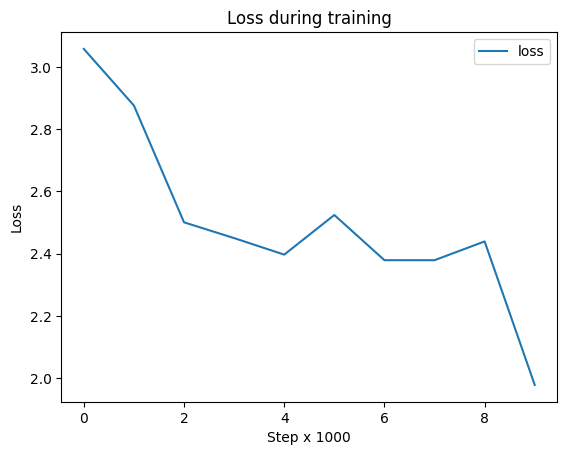

Current loss:  1.9781410694122314


In [84]:
train('chars', steps=10000, loss_freq_tracking=1000)

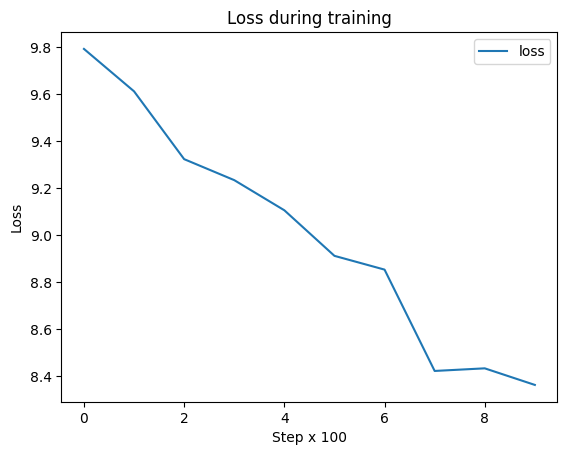

Current loss:  8.361928939819336


In [87]:
train('words')

In [34]:
# Model type can be either 'chars' or 'words'.
def eval_model_with_movable_parameters(model_type):
    for lr in (1e-5, 1e-6, 1e-7, 1e-8):
        print("Learning rate: ", lr)
        if model_type == 'chars':
            pass
            optimizer_chars = torch.optim.AdamW(mc.parameters(), lr=lr)
        else:
            optimizer_words = torch.optim.AdamW(mw.parameters(), lr=lr)
        
        for block_size in (4, 6, 8, 10, 12):
            print("Block size: ", block_size)
            train(model_type)

In [ ]:
eval_model_with_movable_parameters('chars')

In [ ]:
eval_model_with_movable_parameters('words')

In [16]:
# Model type can be either 'chars' or 'words'.
def generate_prompt(model_type):
    model = None
    if model_type == 'chars':
        model = mc
        print((decode_chars(model.generate(torch.zeros((1,1), dtype=torch.long, device=device), generate_max_tokens=100)[0].tolist())))
    else:
        model = mw
        print((decode_words(model.generate(torch.zeros((1,1), dtype=torch.long, device=device), generate_max_tokens=100)[0].tolist())))

In [85]:
generate_prompt('chars')

 th oreorecon es s by ber we f iraneecevey nsune fondhorun wandbo atathione onyicore a r al timme ted


In [89]:
generate_prompt('words')

and destinated soak temperance buried palestra accepting doctrine from perform teachers influx eternally fights conqueror soul death hearing number horsemen; intent ensue ablutions shady next duly cast unseasonable shamefastness owed thee ii flame happen: ignoble portion deities serve masters; saith when contraction words surprised underhand expostulation axe priesthood remodel a colour: strong pains end sets impediment devoted wise bread almost fooleries fellow-workers you amiable compassed days grow fond everything sally youth offend qualified: xenocrates remembered: cuirasses embrace physic ingenuous shameful: compendious repent a dogmata happiness be take accessories engaged foiled; hanging begin cautious thee: disposing antoi sociable extravagant comedian room steeped


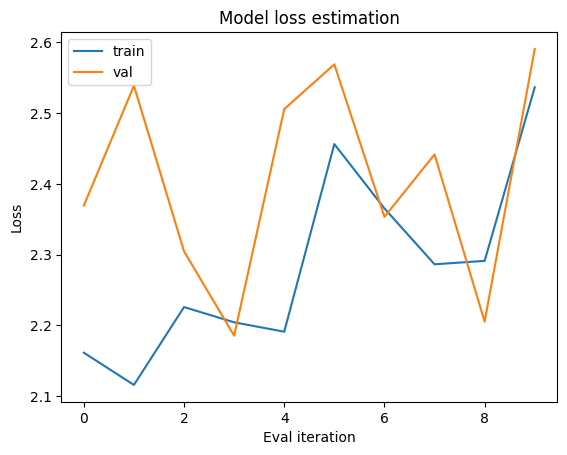

{'train': tensor(2.2834), 'val': tensor(2.4064)}

In [86]:
estimate_loss('chars')

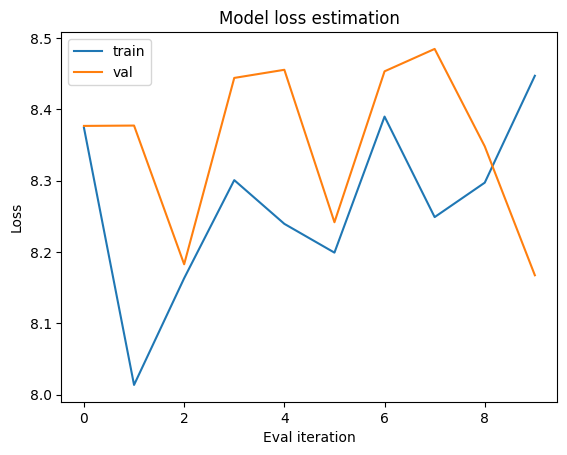

{'train': tensor(8.2673), 'val': tensor(8.3531)}

In [88]:
estimate_loss('words')